# Dependencies

In [163]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures

from matplotlib.colors import ListedColormap
cm_bright = ListedColormap(['#FF0000', '#0000FF'])
%matplotlib inline
from sklearn.metrics import accuracy_score

import sklearn.linear_model

# NeuralNet class

In [164]:
class NeuralNet:
    """
    NN for binary classification
    Attributes:
    ...
    """
    
    def __init__(self, layers_d, normalize = True, learning_rate = 0.01, num_iter = 30000, epsilon = (10)^(-10), k = 500):
        self.layers_d = layers_d # тут лише приховані шари а 0-го та останнього (з одним нейроном) немає
        self.L = len(self.layers_d) + 1 # кількість шарів нейронів в мережі без урахування вихідного
        self.learning_rate = learning_rate
        self.num_iter = num_iter
        self.normalize = normalize
        self.epsilon = epsilon
        self.k = k
    
    def __normalize(self, X, mean = None, std = None):
        """
        Зверніть увагу, що нормалізація вхідних даних є дуже важливою для швидкодії нейронних мереж.
        """
        '''
        X.shape =  (n, m)
        '''
        n = X.shape[0]
        m = mean
        if m is None:
            m = np.mean(X, axis=1).reshape((n, 1))
            '''
            m.shape =  (n, 1)
            '''
        s = std
        if s is None:
            s = np.std(X, axis=1).reshape((n, 1))
            '''
            s.shape =  (n, 1)
            '''
        X_new = (X - m) / s
        return X_new, m, s

    def __sigmoid(self, Z):
        """
        В наступних практичних потрібно буде додати підтримку й інших активаційних функцій - це один з гіперпараметрів. 
        Їх можна вибирати для всіх шарів одночасно або мати різні активаційні функції на кожному з них.
        """
        return 1 / (1 + np.exp(-Z))
    
    def __softmax(self, Z):
        
        x = np.exp(Z)        
        '''
        Z_i.shape  = (n_l, 1)
        x.shape = (n_l, 1)
        '''
        return x / np.sum(x, axis=0, keepdims = True)
    
    def __initialize_parameters(self):
        
        self.parameters = {} # стоврюємо словник зі значеннями W_i та b_i,ключами в якому будуть назви W_1, w_2, ... та b_1, b_2 і т.д
        
        for i in range(1, self.L + 1):
            self.parameters['W_' + str(i)] = np.random.randn(self.layers_d[i], self.layers_d[i - 1])* np.sqrt(2/self.layers_d[i - 1])
            '''
            W_i.shape  = (n_l, n_l-1) # (кількість нейронів на поточному шарі, кількість на попередньому)
            '''
            self.parameters['b_' + str(i)] = np.zeros((self.layers_d[i],1))
            '''
            b_i.shape  = (n_l,1) # (кількість нейронів на поточному шарі, 1)
            '''
       
    def __forward_propagation(self, X):
        
        cache = {} # стоврюємо словник зі значеннями Z_i та A_i,ключами в якому будуть назви A_0, A_1, A_2, ... та Z_1, Z_2 і т.д
        cache['A_0'] = X
        
        for i in range(1, self.L):
            cache['Z_' + str(i)] = np.dot(self.parameters['W_' + str(i)], cache['A_' + str(i - 1)]) + self.parameters['b_' + str(i)]
            '''
            Z_i.shape  = (n_l, 1) = (n_l, n_l-1) * (n_l-1, 1) + (n_l,1)
            '''
            cache['A_' + str(i)] = self.__sigmoid(cache['Z_' + str(i)])
            '''
            A_i.shape  = (n_l, 1) = (n_l, 1)
            '''       
        cache['Z_' + str(self.L)] = np.dot(self.parameters['W_' + str(self.L)], cache['A_' + str(self.L - 1)]) + self.parameters['b_' + str(self.L)]
        cache['A_' + str(self.L)] = self.__softmax(cache['Z_' + str(self.L)])
        '''
        функція softmax на останньому кроці 
        ''' 
        return cache['A_' + str(self.L)], cache
    
    def compute_cost(self, A, Y):
        m = Y.shape[1]
        res = Y * np.log(A) + (1 - Y) * np.log(1 - A)
        J = -(1 / m) * np.sum(res)
        '''
        J.shape  = sum((1, m) x (1, m) - (1, m) x (1, m)) = sum((1, m)) = (1, 1)
        '''
        return J
        
    def __backward_propagation(self, X, Y, cache):
        
        m = X.shape[1]
        gradients = {}
        
        gradients['dZ_' + str(self.L)] = cache['A_' + str(self.L)] - Y
        '''
        dZ_L.shape  = (1, m) - (1, m) = (1, m)
        '''
        gradients['dW_' + str(self.L)] = (1/m) * np.dot (gradients['dZ_' + str(self.L)], cache['A_' + str(self.L - 1)].T)
        '''
        dW_L.shape  = (1, m) * ((n_l-1, m).T) = (1, m) * (m, n_l-1) = (1, n_l-1)
        '''
        gradients['db_' + str(self.L)] = (1/m) * np.sum(gradients['dZ_' + str(self.L)], axis = 1, keepdims = True)
        '''
        db_L.shape  = sum((1, m)) = (1, 1)
        '''
        
        for i in range(self.L - 1, 0, -1):
            dA_i = np.dot (self.parameters['W_' + str(i + 1)].T, gradients['dZ_' + str(i + 1)])
            '''
            dA_i.shape  = (n_l-1, n_l)*(n_l, m) = (n_l-1, m)
            '''
            gradients['dZ_' + str(i)] = np.multiply(dA_i, cache['A_' + str(i)] * (1 - cache['A_' + str(i)]))
            '''
            dZ_i.shape  = (n_l, m)x(n_l, m) = (n_l, m)
            '''
            gradients['dW_' + str(i)] = (1/m) * np.dot (gradients['dZ_' + str(i)], cache['A_' + str(i - 1)].T)
            '''
            dW_i.shape  = (n_l, m)*((n_l-1, n).T) = (n_l, m)*(m, n_l-1) = (n_l, n_l-1)
            '''
            gradients['db_' + str(i)] = (1/m) * np.sum(gradients['dZ_' + str(i)], axis = 1, keepdims = True)
            '''
            db_i.shape = sum((n_l, m)) = (n_l, 1)
            '''       
        
        return gradients
    
    def __update_parameters(self, gradients):
        
        for i in range(1, self.L + 1):
            self.parameters['W_' + str(i)] -= self.learning_rate * gradients['dW_' + str(i)]
            '''
            W_i.shape  = (n_l, n_l-1) # (кількість нейронів на поточному шарі, кількість на попередньому)
            '''
            self.parameters['b_' + str(i)] -= self.learning_rate * gradients['db_' + str(i)]
            '''
            b_i.shape  = (n_l,1) # (кількість нейронів на поточному шарі, 1)
            '''

        
    def fit(self, X_vert, Y_vert, print_cost = True):
        
        X= X_vert.T
        
        n_x = X.shape[0] # визначаємо кількість нейронів у вихідному шарі
                
        lb = LabelBinarizer(neg_label=0, pos_label=1, sparse_output=False) 
        # задаємо перетворення приналежності до класів як 0 і 1 відвідно для кожного прикладу 
        #([0, 0, 1] - приклад з класу 2, [1, 0, 0] - приклад з класу 0, [0, 1, 0] - приклад з класу 1)
        lb.fit(Y_vert)
        
        Y = lb.transform(Y_vert).T        
        final_classes = Y.shape[0] # визначаємо кількість нейронів у вихідному шарі
        
        self.layers_d.insert(0, n_x)
        self.layers_d.append(final_classes) 
        '''
        додаємо вхідний та вихідний шари до прихованих 
        і отримуємо клькість всіх шарів нейронної мережі і кількість нейронів на кожному шарі
        '''
        
        if self.normalize:
            X, self.__mean, self.__std = self.__normalize(X)
        
        costs = []
        
        m = X.shape[1]
        n_x = X.shape[0]
        
        self.__initialize_parameters()
        
        previous_cost = 0;

        for i in range(self.num_iter):
            
            A, cache = self.__forward_propagation(X)

            cost = self.compute_cost(A, Y)

            gradients = self.__backward_propagation(X, Y, cache)

            self.__update_parameters(gradients)

            if print_cost and i % 1000 == 0:
                print("{}-th iteration: {}".format(i, cost))

            if i % 1000 == 0:
                costs.append(cost)
            if (abs(previous_cost - cost) < self.epsilon):
                k = k - 1
                if (k == 0):
                    break;

        if print_cost:
            plt.plot(costs)
            plt.ylabel("Cost")
            plt.xlabel("Iteration, *1000")
            plt.show()
    
    def predict_proba(self, X_vert):
        X = X_vert.T
        if self.normalize:
            X, _, _ = self.__normalize(X, self.__mean, self.__std)    
        
        probs = self.__forward_propagation(X)[0]
        return probs.T
    
    def predict(self, X_vert):
        probs = self.predict_proba(X_vert)
        results_bin = (probs == probs.max(axis=1)[:, None]).astype(int)
        '''
        максимальне значення в кожному рядку перетворюємо на 1 а інші задаємо як 0
        наприклад, 
        a = np.array([[0, 1], [2, 2], [4, 3]])
        (a == a.max(axis=1)[:,None]).astype(int)
        
        Результат : 
        array([[0, 1], [1, 1], [1, 0]])
        '''
        return results_bin


# Custom algorithm 

In [165]:
from sklearn.datasets import load_iris
X, Y = load_iris(return_X_y = True)

In [166]:
print(X.shape)

(150, 4)


In [167]:
Y

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [168]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer(sparse_output=False)

In [169]:
lb = lb.fit(Y) # перетворюємо значення Y масив значеннь з 0 та 1, де 1 - приналежність до відповідного по порядку класу

In [170]:
lb.transform(Y)

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [171]:
cls = NeuralNet([4, 3, 3],normalize = True, learning_rate = 0.05, num_iter = 10000, epsilon = (10)^(-15), k = 100)

0-th iteration: 1.928717242763642
1000-th iteration: 1.8596952067359098
2000-th iteration: 1.1543366779064654
3000-th iteration: 0.7281202201135801
4000-th iteration: 0.5043201302796873
5000-th iteration: 0.36304671767052527
6000-th iteration: 0.2745342178902274
7000-th iteration: 0.21953862824664747
8000-th iteration: 0.18305216482930592
9000-th iteration: 0.15739894751118821


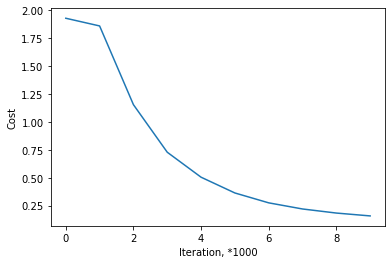

In [172]:
cls.fit(X, Y)

In [173]:
for parameter in cls.parameters:
    print("{} \t {} \t \n {} ".format(parameter, cls.parameters[parameter].shape, cls.parameters[parameter]))

W_1 	 (4, 4) 	 
 [[-0.00900353  0.78558801 -1.03571892 -0.36611324]
 [-1.23274094 -0.94578127 -0.71112294 -0.45059395]
 [ 0.65907452 -0.04916282 -1.583356   -2.08406755]
 [ 0.21696073 -1.29669754  1.26085422  0.36376548]] 
b_1 	 (4, 1) 	 
 [[-0.06618194]
 [ 0.95353266]
 [ 1.97554005]
 [ 0.32244871]] 
W_2 	 (3, 4) 	 
 [[-1.69187837 -0.04139963 -2.50533526  2.82156845]
 [-1.03836074 -0.10443801 -0.75436396  0.29440802]
 [ 1.01985034  1.03460056  3.00028086 -2.02979887]] 
b_2 	 (3, 1) 	 
 [[ 0.70891729]
 [-0.07314384]
 [-0.34590008]] 
W_3 	 (3, 3) 	 
 [[-4.46121326 -1.30005206  1.48383459]
 [ 5.47976788 -0.10294374 -2.17885257]
 [-4.80204286 -0.72026403  4.2899588 ]] 
b_3 	 (3, 1) 	 
 [[ 0.92696194]
 [-0.04992975]
 [ 1.85203693]] 
W_4 	 (3, 3) 	 
 [[ 4.55322505 -6.43740996  3.23180687]
 [-1.22845846  1.1087386   2.47830257]
 [-4.31619948  5.30650489 -6.39851791]] 
b_4 	 (3, 1) 	 
 [[-0.86812252]
 [ 0.03418924]
 [ 0.83393328]] 


In [174]:
Y_prob = cls.predict_proba(X)
Y_prob

array([[9.83711323e-01, 1.62881300e-02, 5.46562265e-07],
       [9.81387986e-01, 1.86113399e-02, 6.74410701e-07],
       [9.82982666e-01, 1.70167483e-02, 5.85569067e-07],
       [9.82147239e-01, 1.78521294e-02, 6.31526325e-07],
       [9.83893567e-01, 1.61058960e-02, 5.36960030e-07],
       [9.83938511e-01, 1.60609543e-02, 5.34664553e-07],
       [9.83494201e-01, 1.65052410e-02, 5.58072241e-07],
       [9.83418810e-01, 1.65806277e-02, 5.62102016e-07],
       [9.80587468e-01, 1.94118116e-02, 7.20738055e-07],
       [9.82175136e-01, 1.78242339e-02, 6.29975709e-07],
       [9.83915701e-01, 1.60837631e-02, 5.35824908e-07],
       [9.83368094e-01, 1.66313416e-02, 5.64809469e-07],
       [9.81643763e-01, 1.83555771e-02, 6.59846018e-07],
       [9.82472839e-01, 1.75265473e-02, 6.13457206e-07],
       [9.84100185e-01, 1.58992890e-02, 5.26247418e-07],
       [9.83996289e-01, 1.60031795e-02, 5.31782694e-07],
       [9.84079547e-01, 1.59199253e-02, 5.27275207e-07],
       [9.83656843e-01, 1.63426

In [175]:
Y_hat = cls.predict(X) # отримуємо масив з 0 та 1 
Y_hat = np.array(lb.inverse_transform(Y_hat)) # перетворюємо в значення класу, до якого належить приклад
print(Y_hat)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2]


In [176]:
custom_accuracy = accuracy_score(Y, Y_hat)
custom_accuracy

0.98

# Scikit-learn Classifier

In [177]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes = (20,), max_iter = 10000)

In [178]:
clf.fit(X, Y)

MLPClassifier(hidden_layer_sizes=(20,), max_iter=10000)

In [179]:
clf.predict_proba(X)

array([[9.98567186e-01, 1.43281337e-03, 1.38052898e-10],
       [9.93652714e-01, 6.34728385e-03, 1.92399012e-09],
       [9.97554436e-01, 2.44556340e-03, 6.87337695e-10],
       [9.94465242e-01, 5.53475378e-03, 3.73589061e-09],
       [9.98983516e-01, 1.01648418e-03, 1.07137089e-10],
       [9.98255148e-01, 1.74485158e-03, 1.95907667e-10],
       [9.97823637e-01, 2.17636181e-03, 1.02737699e-09],
       [9.97520126e-01, 2.47987313e-03, 4.44630928e-10],
       [9.92628193e-01, 7.37179898e-03, 8.01543345e-09],
       [9.95333789e-01, 4.66620994e-03, 1.16411245e-09],
       [9.98890762e-01, 1.10923839e-03, 5.28286432e-11],
       [9.96954849e-01, 3.04515018e-03, 1.11141572e-09],
       [9.95291317e-01, 4.70868215e-03, 1.31239246e-09],
       [9.98092600e-01, 1.90739859e-03, 9.14577349e-10],
       [9.99762669e-01, 2.37330699e-04, 1.62737555e-12],
       [9.99760595e-01, 2.39405240e-04, 4.12493915e-12],
       [9.99397087e-01, 6.02912902e-04, 2.47003072e-11],
       [9.98127466e-01, 1.87253

In [180]:
clf.predict(X)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2])

In [181]:
sk_accuracy = accuracy_score(Y, clf.predict(X))
sk_accuracy

0.98

In [182]:
print("Compare accuracy of custom and sklearn algorithm. \n")
res_compare_test = pd.DataFrame({'accuracy_custom' : [custom_accuracy], 'accuracy_sk' : [sk_accuracy], 'difference' : [abs(custom_accuracy - sk_accuracy)]})
print(res_compare_test)

Compare accuracy of custom and sklearn algorithm. 

   accuracy_custom  accuracy_sk  difference
0             0.98         0.98         0.0
